# Introduction

In this notebook I will be working through [this](https://www.tensorflow.org/tutorials/audio/simple_audio) TensorFlow tutorial. However, I will be using a different dataset with a similar classification task but in a different form. 

In [125]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
from IPython.display import Audio
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.data import AUTOTUNE
import numpy as np

# Data

We will be using the gtzan dataset which is a collection of audio tracks from ten different genres of music. Specifically, we have 1000 clips of 30 second length with 100 tracks per genre encoded at 22050Hz.

In [76]:
(train, val, test), info = tfds.load('gtzan', data_dir='./data',
                        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
                        as_supervised=True, with_info=True, shuffle_files=True)

We have split the datset into 800 tracks for training and 100 tracks each for validation and testing, which we can see verified below.

In [77]:
print(f'Training samples: {len(train)}, Validation samples: {len(val)}, Testing samples: {len(test)}')

Training samples: 800, Validation samples: 100, Testing samples: 100


Below we can see the sample rate and the class label names.

In [78]:
print(f'Sample rate: {info.features["audio"].sample_rate}')

Sample rate: 22050


In [79]:
class_names = info.features['label'].names
print(class_names)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


Now let's look at a single example...

In [80]:
for example in train.take(1):
    print(f'Audio Data: {example[0]}')
    print(f'Label: {example[1]} = {class_names[example[1]]}')

Audio Data: [-1023 -2113 -1898 ... -2732 -3422 -3479]
Label: 9 = rock


We can see that the data consists of a tensor of integer values and a label, we can also listen to the audio.

In [81]:
Audio(example[0].numpy(), rate=22050)

# Pre-processing

We will next define a function to convert a waveform into a log-Mel-spectrogram which is what we will be using as input into our model. Having already gone through most of this in another notebook, I will just define the function. We are using windows of 20ms with 0% overlap and 128 Mel filters

In [84]:
def logMelSpec(wave, length=441, step=441, fft=None, mel_bins=128, 
               rate=22050):
    wave = tf.cast(wave, tf.float32)
    
    s = tf.abs(tf.signal.stft(wave, frame_length=length, 
                              frame_step=step, fft_length=fft))
    
    s_bins = s.shape[-1]
    
    lin2mel = tf.signal.linear_to_mel_weight_matrix(mel_bins, s_bins, 
                                                    rate)
    
    mel_s = tf.tensordot(s, lin2mel, 1)
    
    return tf.expand_dims(tf.transpose(tf.math.log(mel_s+1e-6)), -1)

We can test this with our example above.

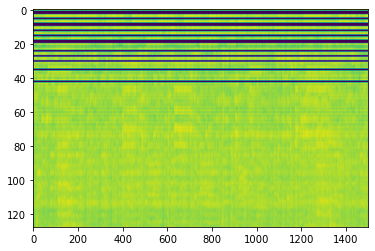

In [86]:
plt.imshow(logMelSpec(example[0]), aspect='auto');

The horizontal black lines are caused by areas in the Mel-spectrogram that have value zero. This would result in negative infinity for the log-Mel-spectrogram, so we have added a small epsilon term to account for this.

We want to apply this process to our whole dataset as that will be what we are using for input. We need to take into account two things as we do this: normalization and sequence length. We will first normalize our wave-form data, and then truncate it so all sequences are the same length.

The normalization constant we will use is 32,768 which follows because the audio we are using is 16-bit which gives an encoded range of -32,768 to 32,767.

The max sequence length we will accept is 330,000 as that is half the minimum sequence length of all the data. I am taking half this minimum value becuase I figure 15 seconds of music should be enough for classification, and it will make training faster.

In [87]:
norm_const = 32768

In [88]:
max_length = int(660000/2)

def process(data, label):
    return logMelSpec(data[:max_length]/norm_const, 441, 441, None, 128, 22050), label

train = train.map(process, num_parallel_calls=AUTOTUNE)
val = val.map(process, num_parallel_calls=AUTOTUNE)
test = test.map(process, num_parallel_calls=AUTOTUNE)

Now let's just make sure that worked as expected...

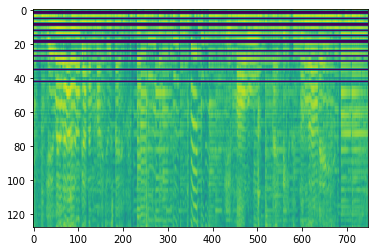

In [89]:
for example in train.take(1):
    plt.imshow(example[0], aspect='auto')

Great!

# Model

Now we will define our model whose job will be to classify input waveforms as one of the ten genres listed above. First, we will adapt a normalization layer to our training dataset, and then we will define the rest of the model.

In [92]:
norm = Normalization()
norm.adapt(train.map(lambda x, _: x))

Our model is a simple CNN but with specific attention being payed to the fact that our sequences are quite long in one dimension. To handle this we have strides of (1,2) in our convolutions.

In [120]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(128, 748, 1)),
    norm,
    keras.layers.Conv2D(32, 5, strides=(1,2), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, strides=(1,2), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, strides=(1,2), activation='relu'),
    keras.layers.MaxPooling2D(),
#     keras.layers.Conv2D(128, 3, activation='relu'),
#     keras.layers.MaxPooling2D(),
#     keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(class_names))
])

model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 128, 748, 1)       3         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 124, 372, 32)      832       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 62, 186, 32)       0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 60, 92, 64)        18496     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 30, 46, 64)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 28, 22, 128)       73856     
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 14, 11, 128)     

In [121]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

# Training

We will train for a maximum of 50 epochs, although we have a callback for early stopping in case the validation accuracy plateaus.

In [105]:
batch_size = 64
train_ds = train.batch(batch_size).cache().prefetch(AUTOTUNE)
val_ds = val.batch(batch_size).cache().prefetch(AUTOTUNE)

In [122]:
epochs = 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,
                   callbacks=keras.callbacks.EarlyStopping(verbose=1, patience=3))

Epoch 1/50
13/13 [==============================] - 11s 841ms/step - loss: 2.4530 - accuracy: 0.1007 - val_loss: 2.2842 - val_accuracy: 0.1600
Epoch 2/50
13/13 [==============================] - 11s 865ms/step - loss: 2.2524 - accuracy: 0.1462 - val_loss: 2.1487 - val_accuracy: 0.1500
Epoch 3/50
13/13 [==============================] - 11s 864ms/step - loss: 2.1723 - accuracy: 0.1794 - val_loss: 2.0991 - val_accuracy: 0.1400
Epoch 4/50
13/13 [==============================] - 12s 887ms/step - loss: 2.1610 - accuracy: 0.1910 - val_loss: 2.0379 - val_accuracy: 0.1900
Epoch 5/50
13/13 [==============================] - 12s 884ms/step - loss: 2.1076 - accuracy: 0.2244 - val_loss: 2.0024 - val_accuracy: 0.2200
Epoch 6/50
13/13 [==============================] - 12s 898ms/step - loss: 2.0677 - accuracy: 0.2632 - val_loss: 1.9588 - val_accuracy: 0.2700
Epoch 7/50
13/13 [==============================] - 12s 892ms/step - loss: 2.0005 - accuracy: 0.2812 - val_loss: 1.9092 - val_accuracy: 0.3200

It looks like we stopped after 29 epochs, and it seems that the validation accuracy reaches a maximum around 50%.

# Testing

Now we test our trained model on the test set...

In [113]:
test_ds = test.batch(batch_size).cache().prefetch(AUTOTUNE)

In [123]:
model.evaluate(test_ds)

2/2 [==============================] - 0s 116ms/step - loss: 1.9861 - accuracy: 0.4800


[1.9860683679580688, 0.47999998927116394]

It looks like we are achieving about 48% accuracy on the test data. This isn't very good, but I think it is worth looking at how the model is failing.

In [132]:
for example in test.take(10):
    label = example[1].numpy()
    inputs = tf.expand_dims(example[0], axis=0)
    output = np.argmax(model.predict(inputs), axis=1)[0]
    
    print(f'True label: {class_names[label]}, Predicted label: {class_names[output]}\n')

True label: country, Predicted label: rock

True label: classical, Predicted label: classical

True label: jazz, Predicted label: jazz

True label: jazz, Predicted label: jazz

True label: blues, Predicted label: country

True label: metal, Predicted label: metal

True label: blues, Predicted label: rock

True label: metal, Predicted label: metal

True label: classical, Predicted label: classical

True label: pop, Predicted label: pop



In the above predictions let us consider the cases where the model fails. Certainly the differences between country, rock, and blues are less varied than the differences between say country and disco, or metal and classical. Therefore I think we should be giving the model a little more credit. If we were to change the labels such that these more similar genres were grouped together I think we would see a much higher accuracy. Of course this isn't the point, but I think it is worth pointing out.